In [1]:
import cv2
from scipy.ndimage import distance_transform_edt as dist
import IPython.display 
import importlib
import skimage.io as imgio
import numpy as np
import os
import torch
import torch.nn.functional as F
import math
import re
from matplotlib import pyplot as plt
from scipy import ndimage
from topoloss4neurons.networks import UNet
import networktraining as nt
import os
import tifffile
import skimage
from utils4 import volInds, renderSWC2volume
from tqdm import tqdm
%matplotlib inline
from scipy.ndimage.morphology import distance_transform_edt
import scipy
# %matplotlib notebook

path_apls: /cvlabdata1/home/zakariya/SegmentingBrains


In [2]:
swcname1 = "/cvlabdata2/home/oner/CarlsData/AL175_stamp_2021_02_10_13_52.ano.eswc"
swcname2 = "/home/oner/samba/TeraConvertion/AL223/AL223_stamp_2021_11_24_17_40.ano.eswc"
swcname3 = "/home/oner/samba/TeraConvertion/AL230/AL230_stamp_2021_12_10_15_51.ano.eswc"
swcname4 = "/home/oner/samba/TeraConvertion/AL236_tera/AL236_stamp_2022_01_25_11_04.ano.eswc"
swcname5 = "/home/oner/samba/TeraConvertion/AL242_tera/AL242_stamp_2022_02_25_11_11.ano.eswc"

In [3]:
def findTahaCubes(brain_i):
    """
    If the annotation is provided, returns the indices of cubes which contains annotated pixels
    """
    xs, ys, zs = getTahaCubeCoords(brain_i)
    coords = getTahaCoords(brain_i)
    cubes = []
    if len(coords) == 0:
        cubes = np.array(np.meshgrid(np.arange(len(xs)),np.arange(len(ys)),np.arange(len(zs)))).T.reshape((-1,3))
    for c in coords:
        xi = np.where(c[0] > np.array(xs))[0][-1]
        yi = np.where(c[1] > np.array(ys))[0][-1]
        zi = np.where(c[2] > np.array(zs))[0][-1]
        if [xi,yi,zi] not in cubes:
            cubes.append([xi,yi,zi])
    return cubes

In [4]:
def readTahaSWC(brain_i):
    """
    Returns the full annotation information for the given brain index
    """
    if brain_i == 175:
        swcfname = swcname1
    elif brain_i == 223:
        swcfname = swcname2
    elif brain_i == 230:
        swcfname = swcname3
    elif brain_i == 236:
        swcfname = swcname4
    elif brain_i == 242:
        swcfname = swcname5
    else:
        return
    nodes=dict()
    for a in open(swcfname):
        if (re.match('\s*\#',a)!=None):
#             print("commment line", a)
            continue
        b=a.split()
        c=map(lambda x: float(x), b)
        d=list(c)
        nodes[int(d[0])]=d
    return nodes

def getTahaCoords(brain_i):
    """
    Returns the location of nodes in the annotations
    """
    nodes = readTahaSWC(brain_i)
    coords = []
    for k in nodes :
        n=nodes[k]
        if brain_i == 175:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 223:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 230:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 236:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 242:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        coords.append([x,y,z])
    return coords

def getTahaCubeCoords(brain_i):
    """
    Returns xyz borders of the cubes according to terafiles
    """
    if brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)"
    elif brain_i == 223:
        direc = "/home/oner/samba/TeraConvertion/AL223/RES(13824x16214x2001)"
    elif brain_i == 230:
        direc = "/home/oner/samba/TeraConvertion/AL230/RES(14504x17408x2468)/"
    elif brain_i == 236:
        direc = "/home/oner/samba/TeraConvertion/AL236_tera/RES(14831x16717x1967)/"
    elif brain_i == 242:
        direc = "/home/oner/samba/TeraConvertion/AL242_tera/RES(15012x17317x1949)/"
    else:
        return
    yind = sorted([int(x)//10 for x in os.listdir(direc) if x.startswith("0") or x.startswith("1")] )
    xind = sorted([int(x.split("_")[-1])//10 for x in os.listdir(os.path.join(direc,"000000")) if x.startswith("0") or x.startswith("1")] )
    zind = sorted([int(x.split("_")[-1][:-4])//10 for x in os.listdir(os.path.join(direc,"000000", "000000_000000")) if x.startswith("0") or x.startswith("1")] )
    
    return xind, yind, zind

In [5]:
def getTahaLabel(brain_i,cube):
    """
    Returns the label of the desired cube in the desired brain
    """
    xs, ys, zs = getTahaCubeCoords(brain_i)
    xi, xf = xs[cube[0]:cube[0]+2]
    yi, yf = ys[cube[1]:cube[1]+2]
    zi, zf = zs[cube[2]:cube[2]+2]
    m=[1,1,1]
    o=[-int(yi),-int(xi),-int(zi)]
    scale_factor=[1,1,1]

    downsampling=torch.tensor(scale_factor,dtype=torch.double)
    offset=torch.tensor(o,dtype=torch.double)
    scale=torch.tensor(m,dtype=torch.double)
    volDims=torch.tensor([3,2,4],dtype=torch.long)
    vols = np.zeros((yf-yi,xf-xi,zf-zi), dtype=np.uint8)
    
    if brain_i == 175:
        renderSWC2volume(swcname1, volDims, vols, scale, offset, downsampling) ## saves the rendering in vols
    elif brain_i == 223:
        renderSWC2volume(swcname2, volDims, vols, scale, offset, downsampling)
    elif brain_i == 230:
        renderSWC2volume(swcname3, volDims, vols, scale, offset, downsampling)
    elif brain_i == 236:
        renderSWC2volume(swcname4, volDims, vols, scale, offset, downsampling)
    elif brain_i == 242:
        renderSWC2volume(swcname5, volDims, vols, scale, offset, downsampling)
    else:
        return
    return vols

In [6]:
def getCube(brain_i, cube):
    """
    Returns the image of the desired cube in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)"
    elif brain_i == 223:
        direc = "/home/oner/samba/TeraConvertion/AL223/RES(13824x16214x2001)"
    elif brain_i == 230:
        direc = "/home/oner/samba/TeraConvertion/AL230/RES(14504x17408x2468)/"
    elif brain_i == 236:
        direc = "/home/oner/samba/TeraConvertion/AL236_tera/RES(14831x16717x1967)/"
    elif brain_i == 242:
        direc = "/home/oner/samba/TeraConvertion/AL242_tera/RES(15012x17317x1949)/"
    elif brain_i == 225:
        direc = "/home/oner/samba/TeraConvertion/AL225_tera/RES(16656x17408x2235)"
    elif brain_i == 250:
        direc = "/home/oner/samba/TeraConvertion/AL250_tera/RES(14680x17258x2068)"
    elif brain_i == 177:
        direc = "/home/oner/samba/TeraConvertion/AL177_tera/RES(16214x17088x2335)"
    elif brain_i == 244:
        direc = "/home/oner/samba/TeraConvertion/AL244_tera/RES(14680x16385x1998)"
    elif brain_i == 261:
        direc = "/home/oner/samba/TeraConvertion/AL261/RES(16727x18258x2168)"
    else:
        return
    xs,ys,zs = getTahaCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.tif".format(ys[y]*10,xs[x]*10,zs[z]*10)
    volume = tifffile.imread(os.path.join(direc,l1,l2,l3))
    return volume.transpose((1,2,0))

def getCubename(brain_i, cube):
    """
    Returns the directory for the desired cube
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)"
    elif brain_i == 223:
        direc = "/home/oner/samba/TeraConvertion/AL223/RES(13824x16214x2001)"
    elif brain_i == 230:
        direc = "/home/oner/samba/TeraConvertion/AL230/RES(14504x17408x2468)/"
    elif brain_i == 236:
        direc = "/home/oner/samba/TeraConvertion/AL236_tera/RES(14831x16717x1967)/"
    elif brain_i == 242:
        direc = "/home/oner/samba/TeraConvertion/AL242_tera/RES(15012x17317x1949)/"
    elif brain_i == 225:
        direc = "/home/oner/samba/TeraConvertion/AL225_tera/RES(16656x17408x2235)"
    elif brain_i == 250:
        direc = "/home/oner/samba/TeraConvertion/AL250_tera/RES(14680x17258x2068)"
    elif brain_i == 177:
        direc = "/home/oner/samba/TeraConvertion/AL177_tera/RES(16214x17088x2335)"
    elif brain_i == 244:
        direc = "/home/oner/samba/TeraConvertion/AL244_tera/RES(14680x16385x1998)"
    elif brain_i == 261:
        direc = "/home/oner/samba/TeraConvertion/AL261/RES(16727x18258x2168)"
    else:
        return
    xs,ys,zs = getTahaCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.tif".format(ys[y]*10,xs[x]*10,zs[z]*10)
    
    return os.path.join("/datasets/" + direc.split("/")[-2],l1,l2,l3)

In [7]:
len(findTahaCubes(223))

99

# Labeling fcts

In [8]:
rendering_path = '/cvlabdata2/home/zakariya/CarlsData/rendering'

In [9]:
def createHisto(brain_i, cubes):
    nbPixelsByCube = []
    for cube in tqdm(cubes):
        label = getTahaLabel(brain_i, cube)
        
        nbPixels = sum(label.flatten())
        nbPixelsByCube.append(nbPixels)
        
    return nbPixelsByCube

In [10]:
def threshold_cubes(brain_i , threshold):
    cubes = np.array(findTahaCubes(brain_i))
    nbWhitePixels = []
    if brain_i == 175:
        nbWhitePixels = tab175
    elif brain_i == 223:
        nbWhitePixels = tab223
    elif brain_i == 230:
        nbWhitePixels = tab230
    elif brain_i == 236:
        nbWhitePixels = tab236
    elif brain_i == 242:
        nbWhitePixels = tab242
    else:
        return

    indices_of_important_cubes = np.array([idx for idx, element in enumerate(nbWhitePixels) if element>threshold])
    important_cubes = cubes[indices_of_important_cubes]
    return important_cubes

In [53]:
def render(brain_i):
    saving_path = f'{rendering_path}/rendered_AL{brain_i}'
    if(f'rendered_AL{brain_i}' not in  os.listdir(rendering_path)):
        os.mkdir(saving_path)
    
    important_cubes = threshold_cubes(brain_i, 100) 
    print(f'{important_cubes.shape[0]} iters')
    for i, cube in enumerate(important_cubes):
        label = getTahaLabel(brain_i, cube).astype('uint8')
        distance_im = distance_transform_edt(1-label).astype('float32')
        
        cube_img = getCube(brain_i, cube).astype('float32')
        cube_img /= 65535
        
        print(cube_img.max())
        print(os.path.join(saving_path,f'cube_{i}.npy'))
        
        np.save(os.path.join(saving_path,f'cube_{i}.npy'), cube_img)
        np.save(os.path.join(saving_path,f'dist_{i}.npy'), distance_im)
        np.save(os.path.join(saving_path,f'label_{i}.npy'), label)
        
        print("3 images saved")
    

(-0.5, 254.5, 254.5, -0.5)

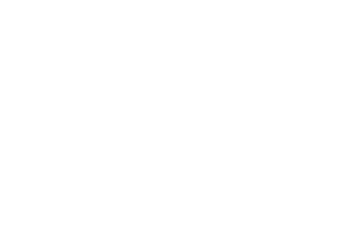

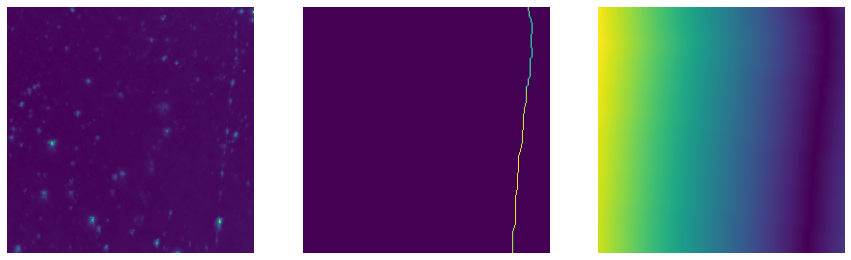

In [88]:
im = np.load("/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_4.npy")
rend =  np.load("/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/label_4.npy")
dist =  np.load("/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/dist_4.npy")
#dist = np.clip(dist, a_min=0, a_max=6)
plt.axis('off')
figure = plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(im.max(2))
plt.axis('off')
figure.add_subplot(132)
plt.imshow(rend.max(2))
plt.axis('off')
figure.add_subplot(133)
plt.imshow(np.array(dist).min(2))
plt.axis('off')

In [48]:
render(175)

124 iters
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_0.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_1.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_2.npy
3 images saved
0.92315555
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_3.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_4.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_5.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_6.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_7.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_8.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_9.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_10.

3 images saved
0.9642176
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_88.npy
3 images saved
0.96318
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_89.npy
3 images saved
0.9659876
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_90.npy
3 images saved
0.8332494
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_91.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_92.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_93.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_94.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_95.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_96.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL175/cube_97.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/ren

In [49]:
render(223)

82 iters
0.8942855
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL223/cube_0.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL223/cube_1.npy
3 images saved
0.8775769
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL223/cube_2.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL223/cube_3.npy
3 images saved
0.9324178
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL223/cube_4.npy
3 images saved
0.972076
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL223/cube_5.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL223/cube_6.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL223/cube_7.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL223/cube_8.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL223/cube_9.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered

In [50]:
render(230)

219 iters
0.32111084
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_0.npy
3 images saved
0.14464027
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_1.npy
3 images saved
0.18957809
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_2.npy
3 images saved
0.41841763
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_3.npy
3 images saved
0.32591745
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_4.npy
3 images saved
0.068757154
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_5.npy
3 images saved
0.48725107
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_6.npy
3 images saved
0.8322881
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_7.npy
3 images saved
0.32663462
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_8.npy
3 images saved
0.19995423
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_9.npy
3 images saved
0.18965438

3 images saved
0.8948348
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_84.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_85.npy
3 images saved
0.8955062
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_86.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_87.npy
3 images saved
0.7770199
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_88.npy
3 images saved
0.4941329
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_89.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_90.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_91.npy
3 images saved
0.82340735
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_92.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_93.npy
3 images saved
0.72364384
/cvlabdata2/home/zakari

3 images saved
0.3548028
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_174.npy
3 images saved
0.056366827
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_175.npy
3 images saved
0.9412833
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_176.npy
3 images saved
0.54073393
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_177.npy
3 images saved
0.23115893
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_178.npy
3 images saved
0.30728617
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_179.npy
3 images saved
0.31769285
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_180.npy
3 images saved
0.13571374
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_181.npy
3 images saved
0.86634624
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_182.npy
3 images saved
0.7385519
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL230/cube_183.npy
3 

In [51]:
render(236)

124 iters
0.989456
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_0.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_1.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_2.npy
3 images saved
0.7447471
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_3.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_4.npy
3 images saved
0.99967957
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_5.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_6.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_7.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_8.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_9.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL2

3 images saved
0.23100634
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_87.npy
3 images saved
0.2839246
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_88.npy
3 images saved
0.36058596
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_89.npy
3 images saved
0.92982376
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_90.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_91.npy
3 images saved
0.43382925
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_92.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_93.npy
3 images saved
0.5600061
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_94.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_95.npy
3 images saved
0.92111087
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL236/cube_96.npy
3 images saved
0.8436103
/cvlabda

In [52]:
render(242)
############## Run the renaming cell ##############

94 iters
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_0.npy
3 images saved
0.89492637
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_1.npy
3 images saved
0.27656978
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_2.npy
3 images saved
0.7166857
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_3.npy
3 images saved
0.34999618
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_4.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_5.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_6.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_7.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_8.npy
3 images saved
0.74728006
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_9.npy
3 images saved
0.9800412
/cvlabdata2/home/zakariya/CarlsData/r

3 images saved
0.9993439
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_87.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_88.npy
3 images saved
0.6881056
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_89.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_90.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_91.npy
3 images saved
1.0
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_92.npy
3 images saved
0.7966125
/cvlabdata2/home/zakariya/CarlsData/rendering/rendered_AL242/cube_93.npy
3 images saved


# Tests on labels

In [32]:
cube_i = [12, 34, 1]

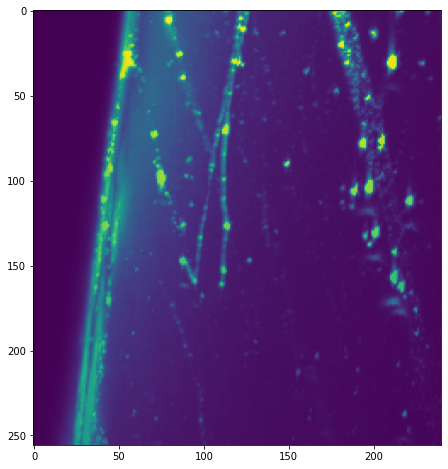

In [33]:
cube1 = getCube(175, cube_i)
plt.figure(figsize=(8,8))
plt.imshow(cube1.max(0))

In [34]:
label1 = getTahaLabel(175, cube_i)
dilated = binary_dilation(label1)

NameError: name 'binary_dilation' is not defined

In [ ]:
plt.imshow(label1.max(0))

In [ ]:
sum(label1.flatten())

In [ ]:
to_show = []
to_show.append(cube1.max(0))
to_show.append(label1.max(0))
to_show.append(distance_transform_edt(1-label1).min(0))
to_show.append(dilated.max(0))

In [ ]:
plt.figure(figsize=(10,10))
for n, im in enumerate(to_show):
    # add a new subplot iteratively
    ax = plt.subplot(1, 4, n + 1)

    # filter df and plot ticker on the new subplot axis
    plt.imshow(im)

    # chart formatting
    plt.axis('off')

# Labeling

## 175

In [20]:
tab175 = createHisto(175, findCubes(175))

100%|█████████████████████████████████████████| 152/152 [21:38<00:00,  8.54s/it]


In [64]:
s = np.array(tab175)
(s>100).sum()

124

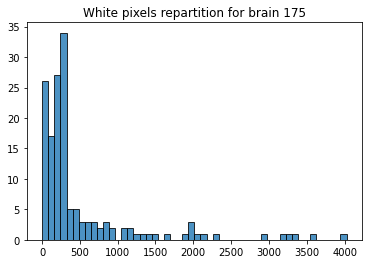

In [109]:
plt.hist(tab175, bins=50, alpha=0.8, ec='black')
plt.title('White pixels repartition for brain 175')
plt.show()

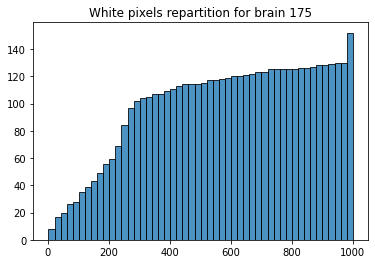

In [282]:
plt.hist(np.clip(tab175, a_min=0, a_max=1000), bins=50, alpha=0.8, ec='black', cumulative=True)
plt.title('White pixels repartition for brain 175')
plt.show()

#keep cubes with 100 pixels or MORE (x axis)

## 230

In [21]:
tab230 = createHisto(230, findTahaCubes(230))
tab236 = createHisto(236, findTahaCubes(236))
tab242 = createHisto(242, findTahaCubes(242))

100%|█████████████████████████████████████████| 127/127 [13:59<00:00,  6.61s/it]


In [22]:
tab223 = createHisto(223, findTahaCubes(223))

100%|███████████████████████████████████████████| 99/99 [11:11<00:00,  6.78s/it]


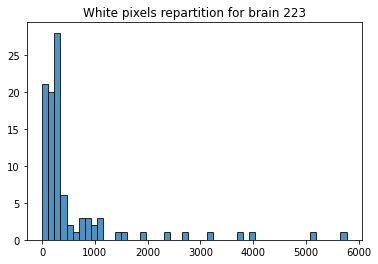

In [209]:
plt.hist(tab223, bins=50, alpha=0.8, ec='black')
plt.title('White pixels repartition for brain 223')
plt.show()

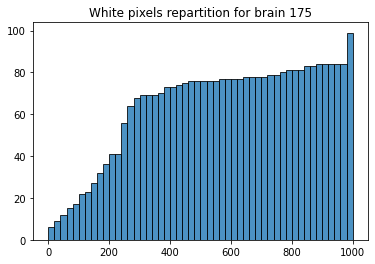

In [219]:
plt.hist(np.clip(tab223, a_min=0, a_max=1000), bins=50, alpha=0.8, ec='black', cumulative=True)
plt.title('White pixels repartition for brain 175')
plt.show()

#keep cubes with 100 pixels or MORE

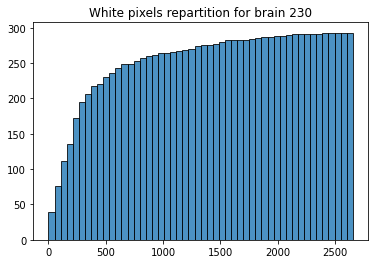

In [91]:
plt.hist(tab230, bins=50, alpha=0.8, ec='black', cumulative=True)
plt.title('White pixels repartition for brain 230')
plt.show()

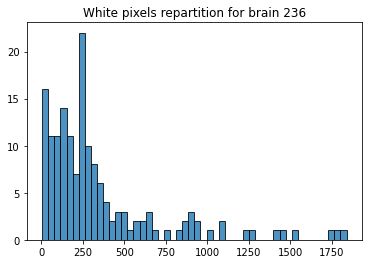

In [211]:
plt.hist(tab236, bins=50, alpha=0.8, ec='black')
plt.title('White pixels repartition for brain 236')
plt.show()

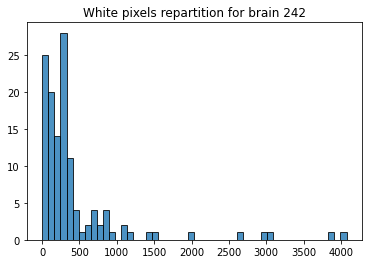

In [212]:
plt.hist(tab242, bins=50, alpha=0.8, ec='black')
plt.title('White pixels repartition for brain 242')
plt.show()

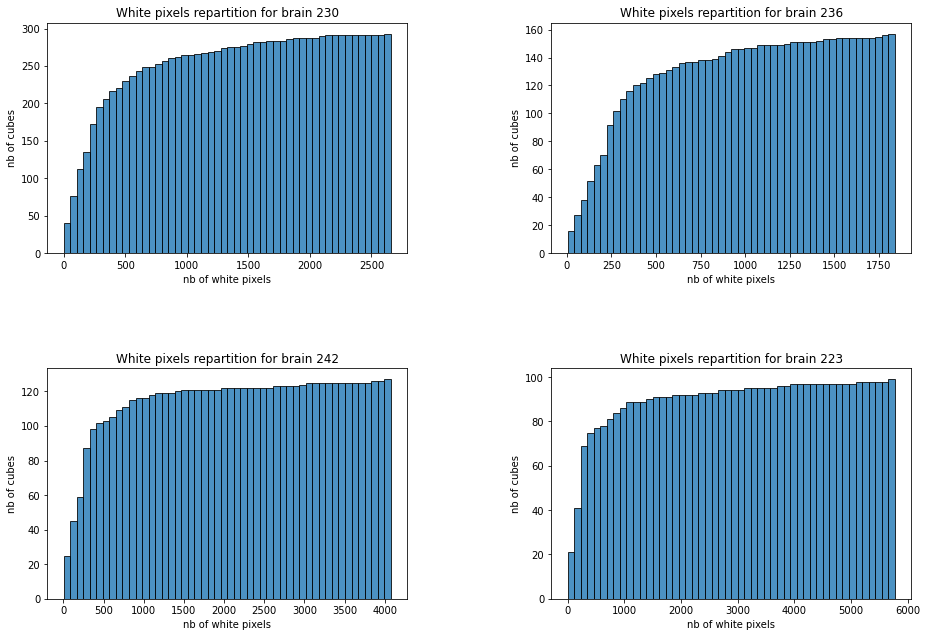

In [101]:
figure = plt.figure(figsize=(15,10))

figure.add_subplot(221)
plt.hist(tab230, bins=50, alpha=0.8, ec='black', cumulative=True)
plt.title('White pixels repartition for brain 230')
plt.xlabel("nb of white pixels")
plt.ylabel("nb of cubes")

figure.add_subplot(222)
plt.hist(tab236, bins=50, alpha=0.8, ec='black', cumulative=True)
plt.title('White pixels repartition for brain 236')
plt.xlabel("nb of white pixels")
plt.ylabel("nb of cubes")

figure.add_subplot(223)
plt.hist(tab242, bins=50, alpha=0.8, ec='black', cumulative=True)
plt.title('White pixels repartition for brain 242')
plt.xlabel("nb of white pixels")
plt.ylabel("nb of cubes")

figure.add_subplot(224)
plt.hist(tab223, bins=50, alpha=0.8, ec='black', cumulative=True)
plt.title('White pixels repartition for brain 223')
plt.xlabel("nb of white pixels")
plt.ylabel("nb of cubes")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)